In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os import cpu_count
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from src.utils import load_data, initialize_model_pipeline, cross_validate_model
from sklearn.metrics import accuracy_score, classification_report
from os import cpu_count

In [107]:
data = pd.read_csv('../data/thea.csv')
X = data.drop('increase_stock', axis=1)
Y = data['increase_stock']

In [108]:
bs_results = []
#only optimize n_estimators, max depth, colsample_bytree
param_grid = {
    'learning_rate': [0.05, .1, .15],
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 5],
    'subsample': [.75],
    'colsample_bytree': [0.75],
    'gamma': [0],
    'min_child_weight': [3],
    'reg_lambda': [0.1]
}

for i in range(100):
    print(f'{i + 1}/100')
    result = {}
    x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                        test_size=1 / 16,  #save 100 holdout
                                                        random_state=i + 1)
    kf = KFold(n_splits=150, shuffle=True) #150 so that we have 10 samples tested on each fold
    m = XGBClassifier()
    search = GridSearchCV(m,
                          param_grid=param_grid,
                          cv=kf,
                          scoring='accuracy',
                          n_jobs=cpu_count() - 1,
                          verbose=2)
    search.fit(x_train, y=y_train)
    result['accuracy'] = accuracy_score(y_test, search.best_estimator_.predict(x_test))
    result['optimistic_accuracy'] = search.best_score_ 
    result['class_report'] = classification_report(y_test, search.best_estimator_.predict(x_test))
    result['best_params'] = search.best_params_
    result['model'] = search.best_estimator_
    bs_results.append(result)


1/100
Fitting 150 folds for each of 18 candidates, totalling 2700 fits
2/100
Fitting 150 folds for each of 18 candidates, totalling 2700 fits
3/100
Fitting 150 folds for each of 18 candidates, totalling 2700 fits
4/100
Fitting 150 folds for each of 18 candidates, totalling 2700 fits
5/100
Fitting 150 folds for each of 18 candidates, totalling 2700 fits
6/100
Fitting 150 folds for each of 18 candidates, totalling 2700 fits
7/100
Fitting 150 folds for each of 18 candidates, totalling 2700 fits
8/100
Fitting 150 folds for each of 18 candidates, totalling 2700 fits
9/100
Fitting 150 folds for each of 18 candidates, totalling 2700 fits
10/100
Fitting 150 folds for each of 18 candidates, totalling 2700 fits
11/100
Fitting 150 folds for each of 18 candidates, totalling 2700 fits
12/100
Fitting 150 folds for each of 18 candidates, totalling 2700 fits
13/100
Fitting 150 folds for each of 18 candidates, totalling 2700 fits
14/100
Fitting 150 folds for each of 18 candidates, totalling 2700 fits
1

In [2]:
# bs_results = pd.DataFrame(bs_results)
bs_results = pd.read_pickle('../data/xg_boost_optimal_results.pkl')

### Now we can look at the results of our *process* as a whole
#### if the model was overfitting too much, we would expect the out of sample scores to be much less

In [3]:
print(f'mew out of sample accuracy - mew optimistic accuracy = {np.mean(bs_results["accuracy"] - bs_results["optimistic_accuracy"])}')
bs_results[['accuracy','optimistic_accuracy']].mean()

mew out of sample accuracy - mew optimistic accuracy = -0.0059866666666667945


accuracy               0.892100
optimistic_accuracy    0.898087
dtype: float64

#### solid evidence that our optimization process is selected such that it does *not* overfit the data
##### Lets look at the confidence interval of our true estimate based on the XG boost process

In [4]:
# noinspection PyArgumentList
quantile_5 = np.percentile(bs_results['accuracy'], 5, interpolation="linear")
# noinspection PyArgumentList
quantile_95 = np.percentile(bs_results['accuracy'], 95, interpolation="linear")
print(f'~95% CI on out of sample accuracy [{quantile_5}, {quantile_95}]')

~95% CI on out of sample accuracy [0.84, 0.93]


Text(0.5, 0, 'Accuracy distribution')

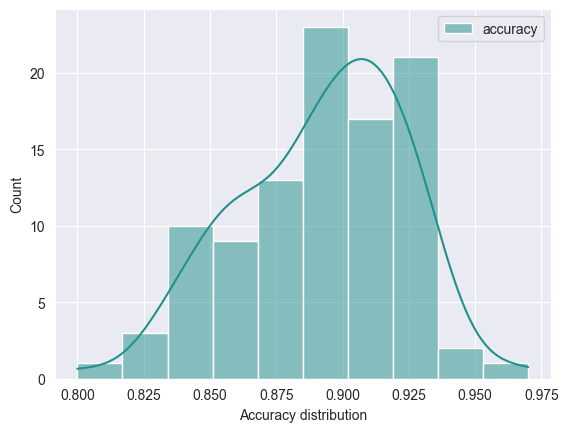

In [5]:
from seaborn import histplot
import matplotlib.pyplot as plt
histplot(data=bs_results[['accuracy']], kde=True, palette='viridis')
plt.xlabel('Accuracy distribution')
# plt.savefig('../figures/xg_boost_accuracy.png', format='png', transparent=True, dpi=300)

##### ^ above, the variance of the estimate might be due to N size of each accuracy prediction (optimistic acc is based on 150 samples of size 100 errors where as the out of sample accuracy is based on one sample of 100 holdout data)

C:\Users\krasky\AppData\Local\Temp\ipykernel_16028\3914939731.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  histplot(data=bs_results['accuracy_diff'], palette='viridis', kde=True)


<Axes: xlabel='accuracy_diff', ylabel='Count'>

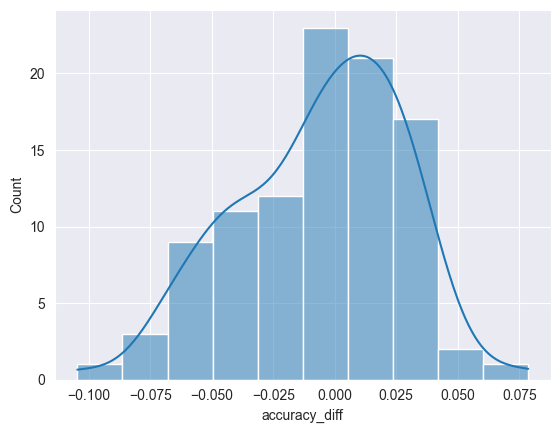

In [7]:
bs_results['accuracy_diff'] =bs_results['accuracy']-bs_results['optimistic_accuracy'] 
histplot(data=bs_results['accuracy_diff'], palette='viridis', kde=True)

### So we have a process
### As a last step, lets run our process on the whole dataset and report the leave-one-out validated score
#### ! question for group: do we run whole process over all data, or bag the hyper-parameters and use that as out final model (and report that leave-one-out) score?

In [7]:
#ex of bagging hyper params
hyper_params_df = pd.DataFrame(bs_results['best_params'].tolist())
hyper_params_df.describe()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_lambda,subsample
count,100.00,100.0,100.000000,100.000000,100.0,100.000000,1.000000e+02,100.00
mean,0.75,0.0,0.093000,4.680000,3.0,100.500000,1.000000e-01,0.75
std,0.00,0.0,0.039581,0.468826,0.0,40.511253,2.789540e-17,0.00
min,0.75,0.0,0.050000,4.000000,3.0,50.000000,1.000000e-01,0.75
25%,0.75,0.0,0.050000,4.000000,3.0,50.000000,1.000000e-01,0.75
50%,0.75,0.0,0.100000,5.000000,3.0,100.000000,1.000000e-01,0.75
75%,0.75,0.0,0.112500,5.000000,3.0,150.000000,1.000000e-01,0.75
max,0.75,0.0,0.150000,5.000000,3.0,150.000000,1.000000e-01,0.75


In [10]:
hyper_params_df['max_depth'].value_counts()

max_depth
5    68
4    32
Name: count, dtype: int64

In [11]:
hyper_params_df['learning_rate'].value_counts()

learning_rate
0.05    39
0.10    36
0.15    25
Name: count, dtype: int64

In [12]:
hyper_params_df['n_estimators'].value_counts()

n_estimators
100    35
150    33
50     32
Name: count, dtype: int64

In [17]:
# look at which n_estimators needed more estimators
hyper_params_df['accuracy'] = bs_results['accuracy']
hyper_params_df['accuracy_diff'] = bs_results['accuracy_diff']
hyper_params_df.select_dtypes(include='number').corr()['accuracy_diff']

colsample_bytree         NaN
gamma                    NaN
learning_rate      -0.008812
max_depth           0.022987
min_child_weight         NaN
n_estimators        0.029007
reg_lambda               NaN
subsample                NaN
accuracy            0.998059
accuracy_diff       1.000000
Name: accuracy_diff, dtype: float64

In [121]:
# bs_results.to_pickle('../xg_boost_optimal_results.pkl')

In [ ]:
# best params grid (no alpha or lambda):
# {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'max_iter': 10000, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 0.75}
# best_score: 0.896875

# best params :
# {'colsample_bytree': 0.75, 'gamma': 0, 'learning_rate': 0.15, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 50, 'reg_lambda': 0.9, 'subsample': 1.0}
# best_score: 0.905

# best RANDOM params:
# {'subsample': 0.5, 'scale_pos_weight': 1, 'reg_lambda': 0.9, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.75}
# best_score: 0.9018750000000001

# best params:
# {'colsample_bytree': 0.75, 'gamma': 0.3, 'learning_rate': 0.075, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 75, 'reg_lambda': 0.1, 'subsample': 0.75}